In [6]:
import numpy as np
import pandas as pd 
import os
import glob
import time
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, confusion_matrix

In [2]:
test_path="D:/FIRE/DATA_THERMAL/TEST"
train_path="D:/FIRE/DATA_THERMAL/TRAINING"
no_of_frames = 12000                                                           # Model Selection Choice
epochs = 3                                                                     # Number of epochs
batch_size = 32                                                                # Batch Size
n_classes =  2                                                                 # Number of Classes
patience = 2                                                                   # Defining Starting Time
categories = os.listdir(train_path)  

In [3]:
print(categories)

['both_fire_and_smoke', 'no_fire_no_smoke']


In [9]:
from tensorflow.keras.applications import EfficientNetV2B3
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input

In [11]:
 base_model = EfficientNetV2B3(weights = 'imagenet', include_top = False, input_shape = (224, 224, 3))

52606240/52606240 [==============================] - 16s 0us/step


In [12]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation = 'relu')(x)
x = Dropout(0.5)(x)
# x = Dense(512, activation = 'relu')(x)
# x = Dense(256, activation = 'relu')(x)
preds = Dense(n_classes, activation = 'softmax')(x)

In [14]:
model = Model(inputs = base_model.input, outputs = preds)
for i, layer in enumerate(model.layers):
    print(i, layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv
4 stem_bn
5 stem_activation
6 block1a_project_conv
7 block1a_project_bn
8 block1a_project_activation
9 block1b_project_conv
10 block1b_project_bn
11 block1b_project_activation
12 block1b_drop
13 block1b_add
14 block2a_expand_conv
15 block2a_expand_bn
16 block2a_expand_activation
17 block2a_project_conv
18 block2a_project_bn
19 block2b_expand_conv
20 block2b_expand_bn
21 block2b_expand_activation
22 block2b_project_conv
23 block2b_project_bn
24 block2b_drop
25 block2b_add
26 block2c_expand_conv
27 block2c_expand_bn
28 block2c_expand_activation
29 block2c_project_conv
30 block2c_project_bn
31 block2c_drop
32 block2c_add
33 block3a_expand_conv
34 block3a_expand_bn
35 block3a_expand_activation
36 block3a_project_conv
37 block3a_project_bn
38 block3b_expand_conv
39 block3b_expand_bn
40 block3b_expand_activation
41 block3b_project_conv
42 block3b_project_bn
43 block3b_drop
44 block3b_add
45 block3c_expand_conv
46 block3c_expand_bn
47 block3c_

In [15]:
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  0           ['rescaling[0][0]']              
                                                                                                  
 stem_conv (Conv2D)             (None, 112, 112, 40  1080        ['normalization[0][0]']      

In [16]:
# Setting each layer as trainable
for layer in model.layers:
    layer.trainable = True

In [17]:
# Defining Image Data Generators
train_datagenerator = ImageDataGenerator(preprocessing_function = preprocess_input,
                                         validation_split = 0.2)

test_datagenerator = ImageDataGenerator(preprocessing_function = preprocess_input)

train_generator = train_datagenerator.flow_from_directory(train_path,
                                                          target_size = (224, 224),
                                                          color_mode = 'rgb',
                                                          batch_size = batch_size,
                                                          class_mode = 'categorical',
                                                          shuffle = True)

validation_generator = train_datagenerator.flow_from_directory(train_path,
                                                               target_size = (224, 224),
                                                               color_mode = 'rgb',
                                                               batch_size = batch_size,
                                                               class_mode = 'categorical',
                                                               subset = 'validation')

test_generator = test_datagenerator.flow_from_directory(test_path,
                                                        target_size = (224, 224),
                                                        color_mode = 'rgb',
                                                        class_mode = 'categorical')

Found 23000 images belonging to 2 classes.
Found 4600 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [18]:
print(train_generator.class_indices)
print(validation_generator.class_indices)
print(test_generator.class_indices)

{'both_fire_and_smoke': 0, 'no_fire_no_smoke': 1}
{'both_fire_and_smoke': 0, 'no_fire_no_smoke': 1}
{'both_fire_and_smoke': 0, 'no_fire_no_smoke': 1}


In [19]:
# Compiling the Model
model.compile(optimizer = "Adam",
              loss = "categorical_crossentropy",
              metrics = ["accuracy"])

In [28]:
try:
    os.mkdir("D:/FIRE/"+"{}_{}b_{}e".format(stime, batch_size, epochs))
except:
    print("Directory already present...")

In [29]:
# CSVLogger
filename = "D:/FIRE/"+"{}_{}b_{}\\file.csv".format(stime, batch_size, epochs)
csv_log = CSVLogger(filename)
filename

'D:/FIRE/1681999071_32b_3\\file.csv'

In [30]:
# Early Stopping
early_stopping = EarlyStopping(patience = patience)

In [31]:
tensorboard = TensorBoard(log_dir = "D:/FIRE/"+"{}_{}b_{}e\logs".format(stime, batch_size, epochs))

In [24]:
# Defining Model Checkpoint
checkpoint_name = "{}_{}b_{}e".format(stime, batch_size, epochs)
checkpoint_path = checkpoint_name + "\cp-{epoch:04d}-{accuracy:.4f}a-{loss:.4f}l-{val_accuracy:.4f}va-{val_loss:.4f}vl.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)
model_checkpoint = ModelCheckpoint(checkpoint_path)

In [32]:
# Training the Model
history = model.fit(train_generator,
                    validation_data = validation_generator,
                    epochs = epochs,
                    )

Epoch 1/3
719/719 [==============================] - 8671s 12s/step - loss: 3.0282e-04 - accuracy: 0.9999 - val_loss: 5.1830e-11 - val_accuracy: 1.0000
Epoch 2/3
719/719 [==============================] - 8363s 12s/step - loss: 7.4246e-06 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/3
719/719 [==============================] - 8426s 12s/step - loss: 3.9159e-07 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


<AxesSubplot: >

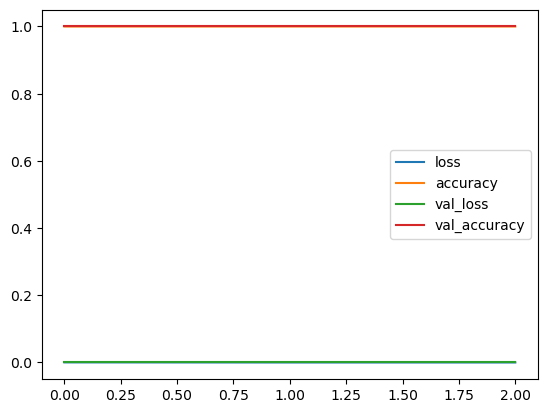

In [33]:
# Plotting the Graph
model_history = pd.DataFrame(history.history)
model_history.plot()

In [47]:
history2 = model.evaluate(test_generator)

1000/1000 [==============================] - 149s 149ms/step - loss: 0.0000e+00 - accuracy: 1.0000


In [48]:
# Image Data Generator
test_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)

test_generator = test_datagen.flow_from_directory(test_path,
                                                  target_size = (224, 224),
                                                  color_mode = "rgb",
                                                  shuffle = False,
                                                  class_mode = 'categorical',
                                                  batch_size = 1)

Found 1000 images belonging to 2 classes.


In [49]:
activities = test_generator.class_indices
print(activities)

{'both_fire_and_smoke': 0, 'no_fire_no_smoke': 1}


In [50]:
def get_activity(val):
    for key, value in activities.items():
        if val == value:
            return key
    return "Invalid"

In [51]:

filenames = test_generator.filenames
nb_samples = len(filenames)

In [52]:
predict = model.predict(test_generator, steps = nb_samples, verbose = 1)

1000/1000 [==============================] - 146s 146ms/step


In [61]:
y_pred = []
for val in predict:
    y_pred.append(get_activity(np.argmax(val)))

y_true = []
for file in filenames:
    y_true.append(file.split("\\")[0])

In [63]:
cm = confusion_matrix(y_true, y_pred)

print(precision_score(y_true, y_pred, average = 'macro',zero_division=1))
print(recall_score(y_true, y_pred, average = 'macro',zero_division=1))
print(f1_score(y_true, y_pred, average = 'macro',zero_division=1))

print(precision_score(y_true, y_pred, average = 'micro',zero_division=1))
print(recall_score(y_true, y_pred, average = 'micro',zero_division=1))
print(f1_score(y_true, y_pred, average = 'micro',zero_division=1))

1.0
1.0
1.0
1.0
1.0
1.0


In [64]:
# Making a Classification Report
print(classification_report(y_true, y_pred))

dataframe = pd.DataFrame(cm)
inv_dict = {v: k for k, v in activities.items()} 
dataframe = dataframe.rename(index = inv_dict)
dataframe = dataframe.rename(columns = inv_dict)

                     precision    recall  f1-score   support

both_fire_and_smoke       1.00      1.00      1.00       500
   no_fire_no_smoke       1.00      1.00      1.00       500

           accuracy                           1.00      1000
          macro avg       1.00      1.00      1.00      1000
       weighted avg       1.00      1.00      1.00      1000



In [65]:
# Saving Conf# Saving Confusion Matrix in CSV format
dataframe.to_csv("D:/FIRE/Perfomance Confusion Matrix.csv")

In [66]:
y_pred

['both_fire_and_smoke',
 'both_fire_and_smoke',
 'both_fire_and_smoke',
 'both_fire_and_smoke',
 'both_fire_and_smoke',
 'both_fire_and_smoke',
 'both_fire_and_smoke',
 'both_fire_and_smoke',
 'both_fire_and_smoke',
 'both_fire_and_smoke',
 'both_fire_and_smoke',
 'both_fire_and_smoke',
 'both_fire_and_smoke',
 'both_fire_and_smoke',
 'both_fire_and_smoke',
 'both_fire_and_smoke',
 'both_fire_and_smoke',
 'both_fire_and_smoke',
 'both_fire_and_smoke',
 'both_fire_and_smoke',
 'both_fire_and_smoke',
 'both_fire_and_smoke',
 'both_fire_and_smoke',
 'both_fire_and_smoke',
 'both_fire_and_smoke',
 'both_fire_and_smoke',
 'both_fire_and_smoke',
 'both_fire_and_smoke',
 'both_fire_and_smoke',
 'both_fire_and_smoke',
 'both_fire_and_smoke',
 'both_fire_and_smoke',
 'both_fire_and_smoke',
 'both_fire_and_smoke',
 'both_fire_and_smoke',
 'both_fire_and_smoke',
 'both_fire_and_smoke',
 'both_fire_and_smoke',
 'both_fire_and_smoke',
 'both_fire_and_smoke',
 'both_fire_and_smoke',
 'both_fire_and_

In [67]:
y_true

['both_fire_and_smoke',
 'both_fire_and_smoke',
 'both_fire_and_smoke',
 'both_fire_and_smoke',
 'both_fire_and_smoke',
 'both_fire_and_smoke',
 'both_fire_and_smoke',
 'both_fire_and_smoke',
 'both_fire_and_smoke',
 'both_fire_and_smoke',
 'both_fire_and_smoke',
 'both_fire_and_smoke',
 'both_fire_and_smoke',
 'both_fire_and_smoke',
 'both_fire_and_smoke',
 'both_fire_and_smoke',
 'both_fire_and_smoke',
 'both_fire_and_smoke',
 'both_fire_and_smoke',
 'both_fire_and_smoke',
 'both_fire_and_smoke',
 'both_fire_and_smoke',
 'both_fire_and_smoke',
 'both_fire_and_smoke',
 'both_fire_and_smoke',
 'both_fire_and_smoke',
 'both_fire_and_smoke',
 'both_fire_and_smoke',
 'both_fire_and_smoke',
 'both_fire_and_smoke',
 'both_fire_and_smoke',
 'both_fire_and_smoke',
 'both_fire_and_smoke',
 'both_fire_and_smoke',
 'both_fire_and_smoke',
 'both_fire_and_smoke',
 'both_fire_and_smoke',
 'both_fire_and_smoke',
 'both_fire_and_smoke',
 'both_fire_and_smoke',
 'both_fire_and_smoke',
 'both_fire_and_

In [68]:
cm

array([[500,   0],
       [  0, 500]], dtype=int64)

In [69]:
predict

array([[1.0000000e+00, 8.7253476e-09],
       [1.0000000e+00, 7.5285227e-09],
       [1.0000000e+00, 6.2958136e-09],
       ...,
       [2.9307612e-11, 1.0000000e+00],
       [1.1643757e-12, 1.0000000e+00],
       [4.3546487e-13, 1.0000000e+00]], dtype=float32)